## Inductive Conformal Prediction Examples

## Required packages

In [1]:
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten
import keras.backend as K
from scipy.stats import beta
from sklearn.model_selection import train_test_split
from keras import datasets, layers, models
import numpy as np
import seaborn as sns
from tqdm import tqdm
from statsmodels.graphics.gofplots import qqplot_2samples
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from scipy import stats
plt.rcParams.update({'font.size': 25})

### Conformal Prediction outline
1. Select an apriori error rate $\alpha\in (0,1)$ depending on the application and leave a calibration set that the model hasn't seen yet.
2. Define a non-conformity score function $s(x, y) \in \mathbb{R}$ that encodes a heuristic notion of uncertainty. 
3.Compute $\hat{q}$ as the $\frac{\left \lceil{(n+1)(1-\alpha}\right \rceil}{n}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_n = s(x_n, y_n)$ on the calibration dataset $D_{cal}$.
4. Compute confidence intervals using $\hat{q}$ as
\begin{equation}
C(x_{val})=\{y: s(x,y)<\hat{q}\}
\end{equation}



Conformal Prediction guarantees coverage property, i.e.,
$\mathbb{P}\left(y_{val} \in C(X_{val})\right) \ge 1-\alpha$

**Assumption:** Data must be i.i.d

## Regression examples

In [2]:
#Load boston housing prices dataset
d=load_boston()
d.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [3]:
X=d['data']
y=d['target']

#Split the dataset in 3 mutually exclusive datasets, train, calibatrion and evaluation (for assessement)

def train_cal_test_split(X,y,random_state=22):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
    X_cal,X_val,y_cal,y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    return X_train,y_train,X_cal,y_cal,X_val,y_val

In [4]:
X_train,y_train,X_cal,y_cal,X_val,y_val=train_cal_test_split(X,y)

### Naive Inductive Conformal Prediction Regression steps

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Define the score function as $s(x,y)= |f(x)-y|$
3. For every $(x_i,y_i) \in D_{cal}$, compute $s_i=s(x_i,y_i)$, where $D_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_i)- \hat{q},f(x_i)+ \hat{q}]
\end{equation}

**Problem:** This guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is allways $2\hat{q}$.




In [5]:
def KNN_train_predict(X_train,y_train,X_test):
    
    model=make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=5,weights='distance'))
    model.fit(X_train,y_train)
    f=model.predict(X_test)
    
    return f,model

def calculate_q_yhat_naive(X_train,y_train,X_cal,y_cal,alpha):
    
    f,model=KNN_train_predict(X_train,y_train,X_cal)
    N=len(y_cal)
    q_yhat=np.quantile(np.abs(y_cal-f),np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat,model

In [6]:
## Train the model and calculate q_yhat for a level alpha

alpha=0.1
q_yhat,model=calculate_q_yhat_naive(X_train,y_train,X_cal,y_cal,alpha)
q_yhat

7.340011671935752

In [7]:
f_val=model.predict(X_val).flatten()

* Evaluate ICP coverage on the validation dataset. It should be greater than $1-\alpha$. Nevertheless, small deviations may happen.

In [8]:
def calculate_coverage(lower_bound,upper_bound,y_true):
    out_of_bound=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bound+=1
            
    return 1-out_of_bound/N

print('Coverage of {}'.format(calculate_coverage(f_val-q_yhat,f_val+q_yhat,y_val)))

Coverage of 0.9291338582677166


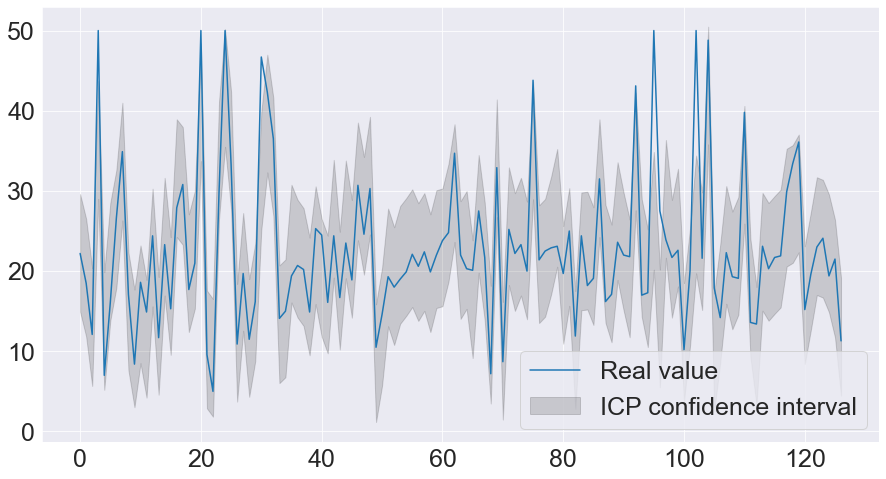

In [9]:

plt.rcParams["figure.figsize"] = (15,8)
sns.set_style("darkgrid", {'axes.grid' : True})
ind=[i for i in range(len(y_val))]
plt.plot(ind,y_val,label='Real value')

plt.fill_between(ind,f_val-q_yhat,f_val+q_yhat,
                 color='k', alpha=.15,label='ICP confidence interval')
plt.legend()
plt.show()

In [10]:
print(2*q_yhat)

14.680023343871504


Distribution of coverage distribution follows the following distribution
\begin{equation}
    \mathbb{E}[1\{y \in C(x_{val})\}| \{(x_i,y_i)\}_{i=1}^{n_{cal}}] \sim  Beta(n_{cal}+1-l,l)
\end{equation}

This way, we can calculate empirical coverage on the T (number of trials) validation sets and verify whether it follows the aforementioned beta distribution.

\begin{equation}
    C_j=\frac{1}{n_{val}} \sum_{i=1}^{n_{val}} 1\{y_i \in C(x_{val})\},\qquad j \in \{1,2,...,T\}.
\end{equation}

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.39it/s]


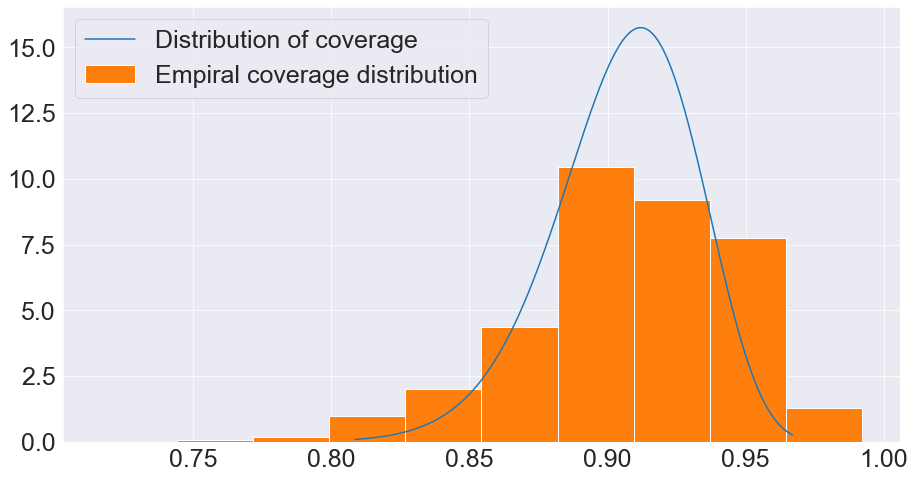

In [11]:
T=10000
C_j=[]

n_cal=X_cal.shape[0]
l=np.floor((n_cal+1)*(alpha))
a=n_cal+1-l
b=l

for j in tqdm(range(T)):
    X_train,y_train,X_cal,y_cal,X_val,y_val=train_cal_test_split(X,y,random_state=j)
    q_yhat,model=calculate_q_yhat_naive(X_train,y_train,X_cal,y_cal,alpha)
    f_val=model.predict(X_val).flatten()
    C_j.append(calculate_coverage(f_val-q_yhat,f_val+q_yhat,y_val))

x=np.linspace(beta.ppf(0.001,a,b),beta.ppf(0.999,a,b),T)
plt.plot(x,beta.pdf(x, a, b),label='Distribution of coverage')
plt.hist(C_j,density=True,label='Empiral coverage distribution')
plt.legend()
plt.show()
    

In [12]:
np.mean(C_j) # should be close to 1-alpha

0.9062393700787403

In [13]:
(a)/(a+b) # real mean of beta distribution

0.905511811023622

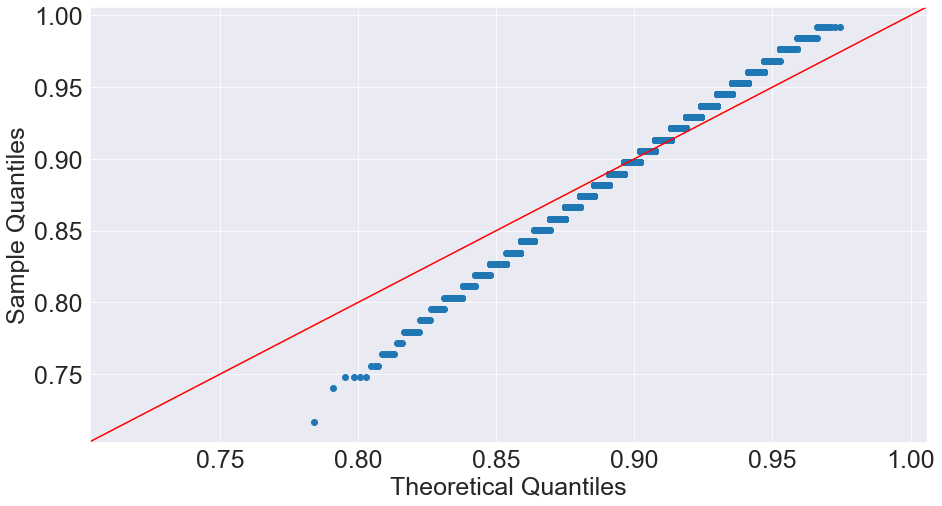

In [14]:
##qqplot compares the quantiles of the theoretical distribution against the sample quantiles.

rv = beta(a, b)
sm.qqplot(np.array(C_j),dist=rv,line='45')
plt.show()

In a statiscian manner we can compare two sample with Kolmogorov-Smirnov two sample test. 
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [ ]:
#ks_2samp(C_j,beta.pdf(x, a, b))

# Adaptative intervals

## Conformalized residual fitting 

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Predict with model f on the first calibration set $D_{cal1}$ and store the absolute residuals $\epsilon_i=|y_i-f(x_i)|$ for every $i \in \{1,2,...,n_{cal1}\}$
3. Train a model $r:\mathbb{R}^d \rightarrow \mathbb{R}$ on $\{(x_i,\epsilon_i)\}_{i=1}^{n_{cal1}}$
2. Define the score function as $s(x,y)= \frac{|f(x)-y|}{r(x)}$
3. For every $(x_i,y_i) \in D_{cal2}$, compute $s_i=s(x_i,y_i)$, where $D_{cal2}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal2}}$ is the second calibration dataset.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal2}+1)(1-\alpha}\right \rceil}{n_{cal2}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal2}} = s(x_{n_{cal2}}, y_{n_{cal2}})$ on the second calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_{val})- \hat{q}r(x_{val}),f(x_{val})+ \hat{q}r(x_{val})]
\end{equation}

In [15]:
def train_cal_test_split2(X,y,random_state=22):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
    X_cal,X_val,y_cal,y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    X_cal1, X_cal2,y_cal1, y_cal2=train_test_split(X_cal, y_cal, test_size=0.5, random_state=random_state)
    
    return X_train,y_train,X_cal1,y_cal1,X_cal2,y_cal2,X_val,y_val

In [16]:
X_train,y_train,X_cal1,y_cal1,X_cal2,y_cal2,X_val,y_val=train_cal_test_split2(X,y)

In [17]:
alpha=0.1
model=make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=5,weights='distance'))
# train
model.fit(X_train,y_train)
#calculate residuals
r_y=np.abs(y_cal1-model.predict(X_cal1))
#fit model residual on residuals
model_r=make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=5,weights='distance'))
model_r.fit(X_cal1,r_y)
#check for coverage without ICP
f=model.predict(X_val)
f_r=model_r.predict(X_val)
lower_bound=f-f_r
upper_bound=f+f_r
print('Coverage without conformal of {}'.format(calculate_coverage(lower_bound,upper_bound,y_val)))

#calculate q_yhat
f=model.predict(X_cal2)
f_r=model_r.predict(X_cal2)
N=len(y_cal2)
q_yhat=np.quantile(np.abs(y_cal2-f)/f_r,np.ceil((N+1)*(1-alpha))/N)
print(q_yhat)
#predict with 1-alpha confidence
f=model.predict(X_val)
f_r=model_r.predict(X_val)
lower_bound=f-q_yhat*f_r
upper_bound=f+q_yhat*f_r
print('Coverage with conformal of {}'.format(calculate_coverage(lower_bound,upper_bound,y_val)))

Coverage without conformal of 0.6692913385826771
2.9708977779642316
Coverage with conformal of 0.937007874015748


In [18]:
np.mean(upper_bound-lower_bound)

15.837515787890418

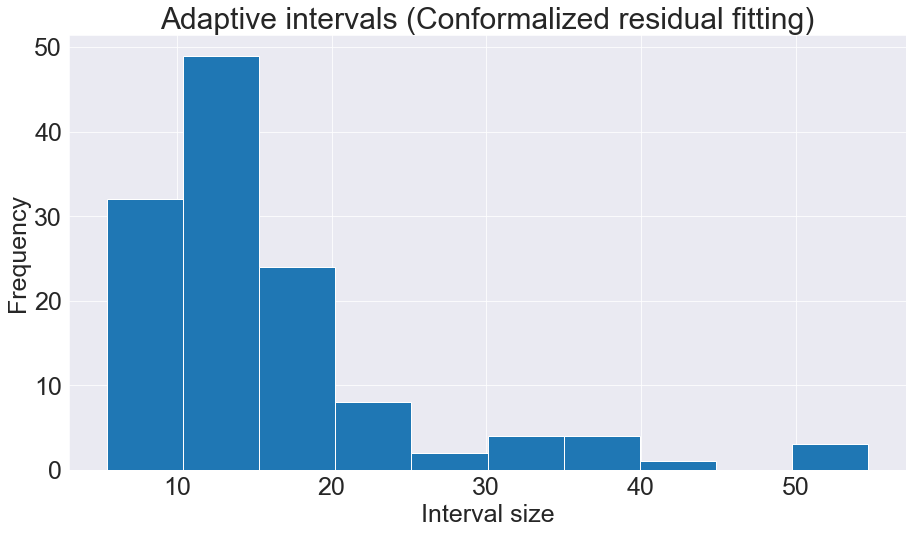

In [19]:
plt.hist(np.abs(upper_bound-lower_bound))
plt.xlabel('Interval size')
plt.ylabel('Frequency')
plt.title('Adaptive intervals (Conformalized residual fitting)')
plt.show()

In [20]:
q_yhat,model=calculate_q_yhat_naive(X_train,y_train,X_cal1,y_cal1,alpha)

### Conformalized Quantile Regression

Solution for the foregoing problem: **Quantile Regression** <br>

Quantile regression algorithm attempts to learn the $\alpha \in (0,1)$ quantile of $Y_{test}|X_{test} = x$ for each possible value of x.
For that purpose. we shall use the quantile loss, also known as pinball loss.


**Problem:** We only get a estimate of the real quantiles $\left[\hat{t}_{\frac{\alpha}{2}},\hat{t}_{1-\frac{\alpha}{2}}\right]$. Although this provides good coverage, it doesn't guarantee $1-\alpha$ coverage.

**Solution:** Conformalize it with s given by
$$s(x,y)=max\left(\hat{t}_{\frac{\alpha}{2}}-y,y-\hat{t}_{1-\frac{\alpha}{2}}\right)$$
* Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_2} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.

* Predict with $1-\alpha$ confidence as
\begin{equation}
\left[\hat{t}_{\frac{\alpha}{2}}-\hat{q},\hat{t}_{1-\frac{\alpha}{2}}+\hat{q} \right]
\end{equation}

In [21]:
#quantile loss function

def tilted_loss(q,y,f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted (predicted) value.
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [22]:
# Feedforward neural network QR architecture

def QuantileRegressionModel(dim,qs=[0.1, 0.5, 0.9]):
    ipt_layer = Input((dim,))
    layer1 = Dense(100, activation='relu')(ipt_layer)
    layer2 = Dense(100, activation='relu')(layer1)
    
    out1 = Dense(1, name='out1')(layer2)
    out2 = Dense(1, name='out2')(layer2)
    out3 = Dense(1, name='out3')(layer2)
    
    q1, q2, q3 = qs
    model = Model(inputs=ipt_layer, outputs=[out1, out2, out3])
    model.compile(loss={'out1': lambda y,f: tilted_loss(q1,y,f),
                        'out2': lambda y,f: tilted_loss(q2,y,f),
                        'out3': lambda y,f: tilted_loss(q3,y,f),}, 
                  loss_weights={'out1': 1, 'out2': 1, 'out3': 1},
                 optimizer='adam')
    
    return model

In [23]:
alpha=0.1
qs=[alpha/2, 0.5,1-alpha/2]
X_train,y_train,X_cal,y_cal,X_val,y_val=train_cal_test_split(X,y)

model=QuantileRegressionModel(X_train.shape[1],qs=qs)

model.fit(X_train,y_train, epochs=1000, batch_size=32, verbose=0)

In [24]:
forecast=model.predict(X_val)

In [25]:
lower_bound=forecast[0].flatten()
upper_bound=forecast[2].flatten()
print('QR Coverage without conformal of {}'.format(calculate_coverage(lower_bound,upper_bound,y_val)))

QR Coverage without conformal of 0.6929133858267716


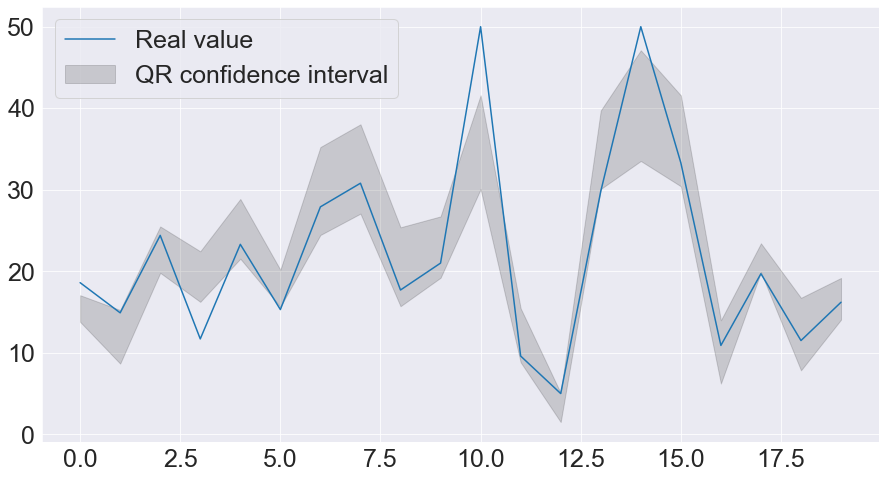

In [26]:
ind=[i for i in range(len(forecast[1].flatten()))]
ind=[i for i in range(20)]

plt.plot(ind,y_val[10:30],label='Real value')
a=lower_bound[10:30]
b=upper_bound[10:30]

plt.fill_between(ind,lower_bound[10:30],upper_bound[10:30],
                 color='k', alpha=.15,label='QR confidence interval')
plt.legend()
plt.show()

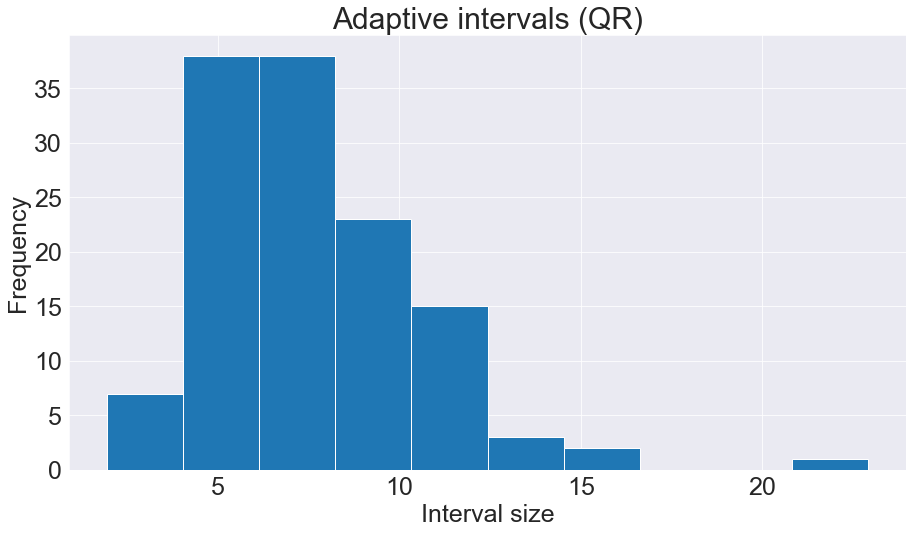

In [27]:
plt.hist(np.abs(upper_bound-lower_bound))
plt.xlabel('Interval size')
plt.ylabel('Frequency')
plt.title('Adaptive intervals (QR)')
plt.show()

### Calibration step (QR)

In [28]:
def calibrate_qyhat(y_true,lower_bound,upper_bound,alpha):
    
    N=len(y_true)
    s=np.amax([lower_bound-y_true,y_true-upper_bound],axis=0)
    q_yhat=np.quantile(s,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

forecast=model.predict(X_cal)
lower_bound=forecast[0].flatten()
upper_bound=forecast[2].flatten()

q_yhat=calibrate_qyhat(y_cal,lower_bound,upper_bound,alpha)
print(q_yhat)
forecast=model.predict(X_val)
lower_bound=forecast[0].flatten()-q_yhat
upper_bound=forecast[2].flatten()+q_yhat

print('QR Coverage with conformal of {}'.format(calculate_coverage(lower_bound,upper_bound,y_val)))

3.032838987925696
QR Coverage with conformal of 0.9212598425196851


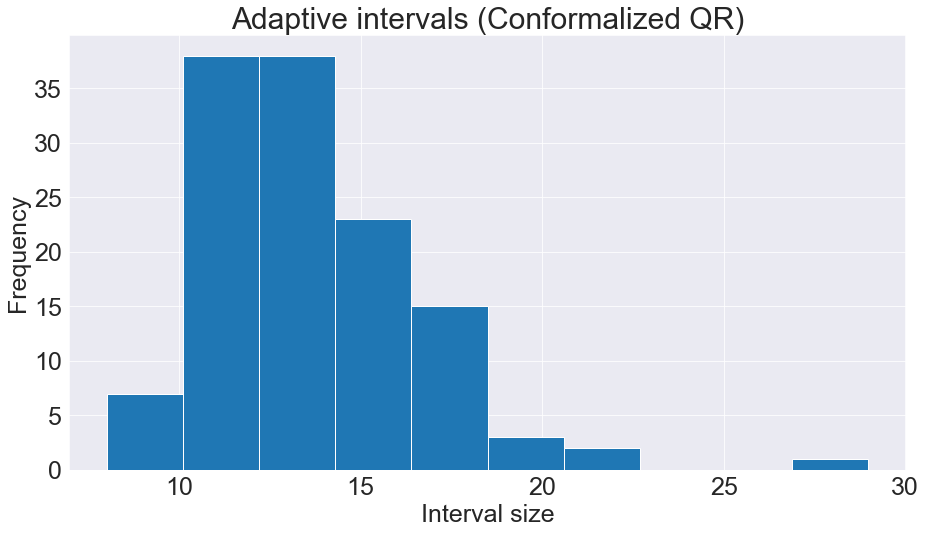

In [29]:
plt.hist(np.abs(upper_bound-lower_bound))
plt.xlabel('Interval size')
plt.ylabel('Frequency')
plt.title('Adaptive intervals (Conformalized QR)')
plt.show()

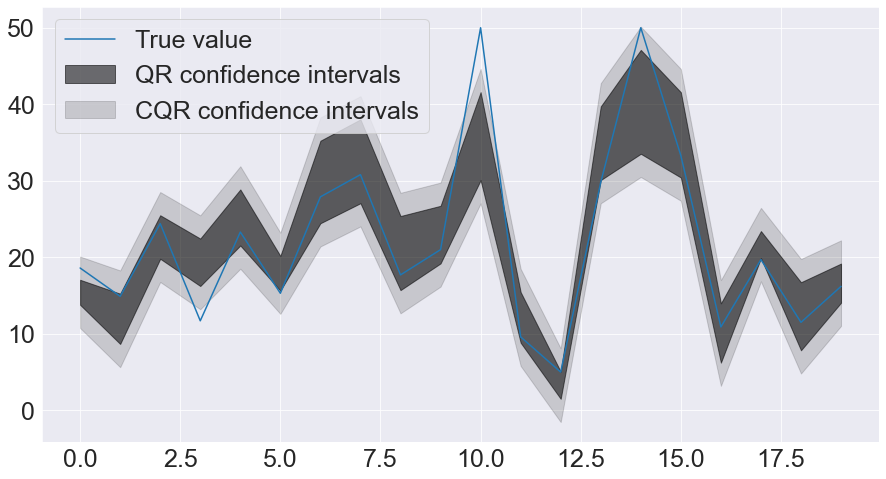

In [30]:
ind=[i for i in range(forecast[0].shape[0])]
ind=[i for i in range(20)]
plt.plot(ind,y_val[10:30],label='True value')

plt.fill_between(ind,a,b,
                 color='k', alpha=.55,label='QR confidence intervals')

plt.fill_between(ind,lower_bound[10:30],upper_bound[10:30],
                 color='black', alpha=.15,label='CQR confidence intervals')
plt.legend(loc='upper left')
plt.show()

In [31]:
np.mean(upper_bound-lower_bound)

13.679092

# Classification 

In classification we want to output a set of classes with coverage guarantee, i.e., $P\left(Y_{val} \in C(X_{val})\right) \ge 1-\alpha$.


In [32]:
#download cifar10 dataset

(X_train, y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()
X_cal,X_val,y_cal,y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=30)

In [33]:
X_val.shape

(5000, 32, 32, 3)

In [34]:
y_train = y_train.reshape(-1,)
y_cal = y_cal.reshape(-1,)
y_val = y_val.reshape(-1,)
print(y_train.shape)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

(50000,)


In [35]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

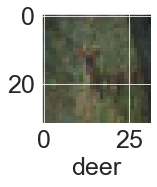

In [36]:
plot_sample(X_train, y_train,10)

In [37]:
#normalization

X_train = X_train / 255.0
X_cal = X_cal / 255.0
X_val = X_val/225.0

In [38]:
# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [39]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.fit(X_train,y_train,batch_size=100,epochs=50)

Epoch 1/50
500/500 [==============================] - 21s 40ms/step - loss: 1.6874 - accuracy: 0.3800
Epoch 2/50
500/500 [==============================] - 21s 42ms/step - loss: 1.3512 - accuracy: 0.5089
Epoch 3/50
500/500 [==============================] - 26s 51ms/step - loss: 1.2025 - accuracy: 0.5653
Epoch 4/50
500/500 [==============================] - 25s 50ms/step - loss: 1.1011 - accuracy: 0.6046
Epoch 5/50
500/500 [==============================] - 24s 48ms/step - loss: 1.0223 - accuracy: 0.6348
Epoch 6/50
500/500 [==============================] - 24s 48ms/step - loss: 0.9647 - accuracy: 0.6572
Epoch 7/50
500/500 [==============================] - 24s 48ms/step - loss: 0.9074 - accuracy: 0.6761
Epoch 8/50
500/500 [==============================] - 24s 48ms/step - loss: 0.8590 - accuracy: 0.6951
Epoch 9/50
500/500 [==============================] - 25s 50ms/step - loss: 0.8199 - accuracy: 0.7092
Epoch 10/50
500/500 [==============================] - 23s 47ms/step - loss: 0.788

# Classification Naive method
1. Train a ML model $f:\mathbb{R}^{32 \times 32 \times 3} \rightarrow (0,1)^{10}$ on $D_{train}$
2. Define $s(x,y)= 1-f(x)_{y_{true}}$ where $f(x)_{y_{true}}$ is the softmax output of the true class
3. Compute $s_1,s_2,...,s_{n_{cal}}$ on the calibration set $D_{cal}$
4. Compute $\hat{q}$ as the $\frac{\left \lceil (n_{cal}+1)(1-\alpha)\right \rceil}{n_{cal}}$ quantile of the aforementioned scores.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
C(x_{val})=\{y: f(x_{val})_y \geq 1- \hat{q}\}
\end{equation}

In [41]:
#function to calculate q_yhat

def calculate_qyhat_naive_classification(softmax_outputs,y_cal,alpha):
    N=softmax_outputs.shape[0]
    scores=np.zeros(N)
    
    for i in range(N):
        true_softmax_output=softmax_outputs[i][y_cal[i]]
        scores[i]= 1-true_softmax_output
        
    q_yhat=np.quantile(scores,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

#function to get predict sets
def get_confsets_naive(model,X_val,y_val,q_yhat):
    softmax_outputs = model.predict(X_val)
    N=softmax_outputs.shape[0]
    
    conf_sets=[]
    
    for i in range(N):
        aux=[]
        for j in range(softmax_outputs.shape[1]):
            if softmax_outputs[i][j]>= 1-q_yhat:
                aux.append(j)
        conf_sets.append(aux)
        
    return conf_sets
                
#function to evaluate coverage

def calculate_coverage(conf_pred,y_true):
    s=0
    
    for i in range(len(conf_pred)):
        if y_true[i] in conf_pred[i]:
            s+=1
    
    return s/len(y_true)

        
    

In [42]:
alpha=0.1
softmax_outputs=model.predict(X_cal)
q_yhat=calculate_qyhat_naive_classification(softmax_outputs,y_cal,alpha)
q_yhat

0.96457949661538

In [43]:
conf_sets=get_confsets_naive(model,X_val,y_val,q_yhat)
calculate_coverage(conf_sets,y_val)

0.8818

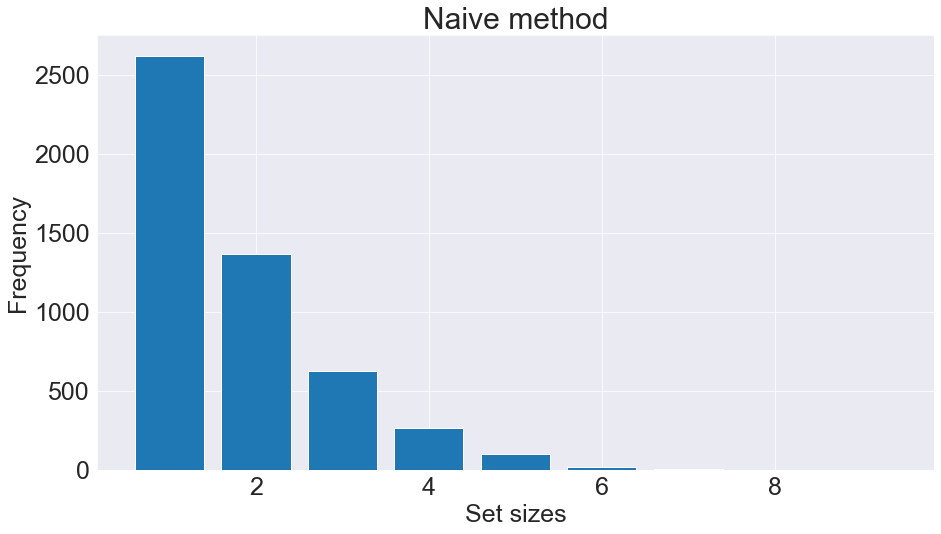

In [44]:
sets_dim=[len(set_conf) for set_conf in conf_sets]
plt.bar(dict(pd.Series(sets_dim).value_counts()).keys(),dict(pd.Series(sets_dim).value_counts()).values())
plt.xlabel('Set sizes')
plt.ylabel('Frequency')
plt.title('Naive method')
plt.show()

Text(0, 0.5, 'Coverage')

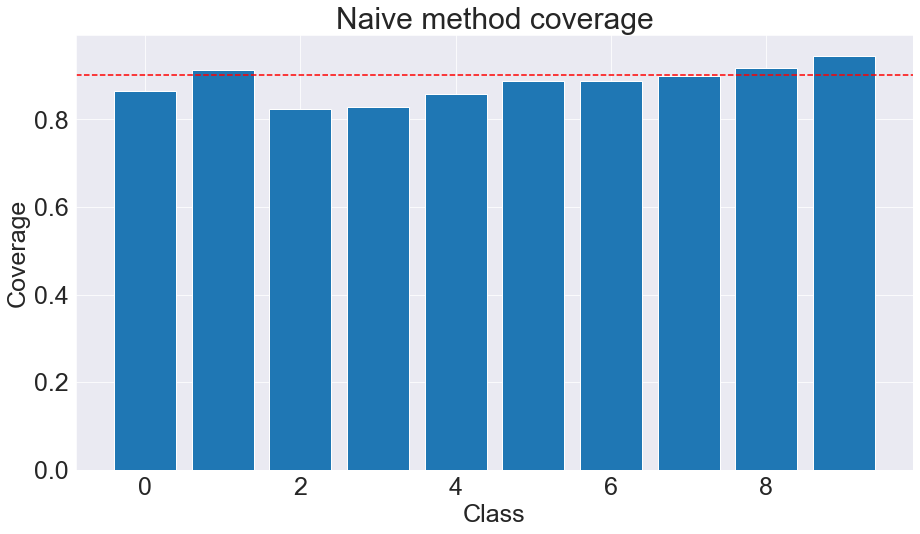

In [45]:
d1=np.zeros(10)
d2=np.zeros(10)

for i in range(len(conf_sets)):
    d2[y_val[i]]+=1
    
    if y_val[i] in conf_sets[i]:
        d1[y_val[i]]+=1




plt.bar([i for i in range(10)],d1/d2)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Naive method coverage')
plt.xlabel('Class')
plt.ylabel('Coverage')

### Density based approach

Suppose $\pi(x)$ a permutation of $f(x)$ that orders the softmax output in descending order, i.e., from the most likely class to the less likely.

1. Choose  $s(x,y)=\sum_{i=1}^k\pi(x)_y$ where k is the minimum number of classes we have to go through until we reach the true class.
2.
2. $s(x,y)= \sum_{i=1}^{k}\hat{\pi}(x)_{y_i}$, where k is the minimum number of classes used untill we find the true class.
3.Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_n = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
4. Prediction sets with $1-\alpha$ confidence as 
\begin{equation}
    C(x_{val})=\{y:\sum_{i=1}^k\pi(x)_y \ge \hat{q}\}.
\end{equation}

In [46]:
#alpha=0.1
#y_pred = model.predict(X_cal)
#y_classes = [np.argmax(element) for element in y_pred]
#N=X_cal.shape[0]

def get_ind(y_pred_i,y_test_i):
    return np.where(np.sort(y_pred_i)[::-1]==y_pred_i[y_test_i])[0][0]

def calculate_qyhat_classification(model,X_cal,y_cal,alpha=0.05):
    y_pred = model.predict(X_cal)
    sums_density=[]
    N=y_cal.shape[0]
    
    for i in range(N):
        sum_density=0
        ind=get_ind(y_pred[i],y_cal[i])
        sums_density.append(np.sum(np.sort(y_pred[i])[::-1][0:ind+1]))
        
    q_yhat=np.quantile(sums_density,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

def get_classes(model,X_val,q_yhat):
    
    y_pred = model.predict(X_val)
    
    conf_sets=[]
    
    for i in range(y_pred.shape[0]):
        a=np.where(np.cumsum(np.sort(y_pred[i])[::-1])>q_yhat)[0][0]
        
        classes=[]
        
        for j in range(a+1):
            ind=np.where(y_pred==np.sort(y_pred[i])[::-1][j])[1][0]
            classes.append(ind)
        
        conf_sets.append(classes)
        
    return conf_sets


In [47]:
alpha=0.1
q_yhat=calculate_qyhat_classification(model,X_cal,y_cal,alpha)
q_yhat

0.999991661298275

In [48]:
conf_sets=get_classes(model,X_val,q_yhat)

In [49]:
calculate_coverage(conf_sets,y_val)

0.9044

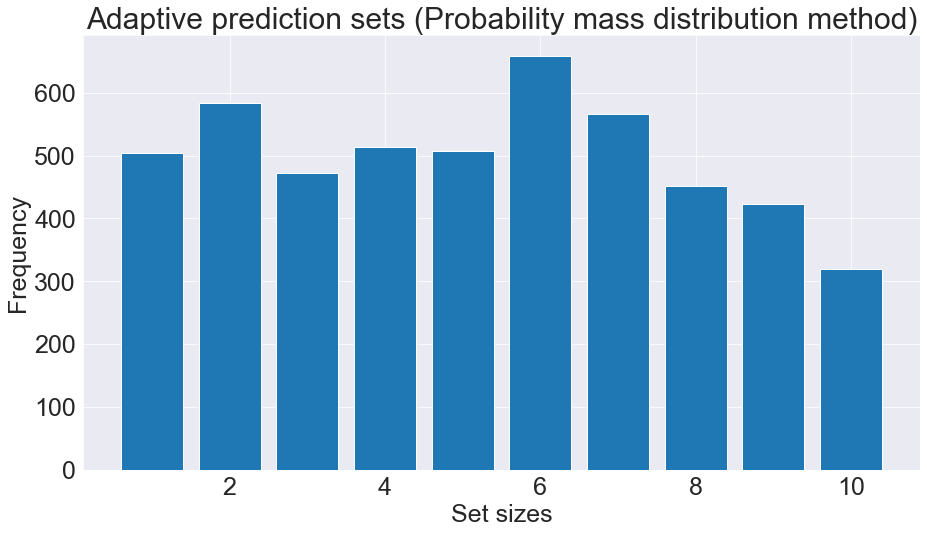

In [50]:
sets_dim=[len(set_conf) for set_conf in conf_sets]
plt.bar(dict(pd.Series(sets_dim).value_counts()).keys(),dict(pd.Series(sets_dim).value_counts()).values())
plt.xlabel('Set sizes')
plt.ylabel('Frequency')
plt.title('Adaptive prediction sets (Probability mass distribution method)')
plt.show()

Text(0, 0.5, 'Coverage')

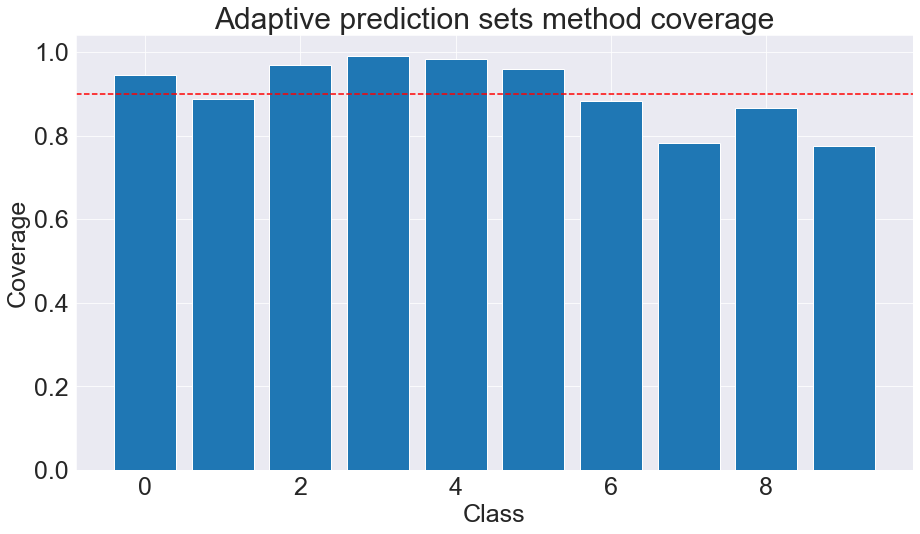

In [51]:
d1=np.zeros(10)
d2=np.zeros(10)

for i in range(len(conf_sets)):
    d2[y_val[i]]+=1
    
    if y_val[i] in conf_sets[i]:
        d1[y_val[i]]+=1




plt.bar([i for i in range(10)],d1/d2)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Adaptive prediction sets method coverage')
plt.xlabel('Class')
plt.ylabel('Coverage')

## Class-balanced conformal prediction
Equal to the naive method, however we calculate $\hat{q}^{(0)},\hat{q}^{(1)},...,\hat{q}^{(9)}$, one for each class, i.e., we stratify by class. Then we get prediction sets with $1-\alpha$ confidence as $C(x_{val})=\{y: f(x_{val})_y \geq 1- \hat{q}^{(y)}\}$.

* https://ardigen.com/conformal-predictionin-classification/

In [52]:
def Calculate_q_yhats(model,X_cal,alpha=0.05):
    y_pred = model.predict(X_cal)
    N=X_cal.shape[0]
    d_alpha={}
    d_alpha_q_yhats={}
    conf_pred=[]

    for i in range(N):
        real_class=y_cal[i]
        prob=1-y_pred[i][real_class]
        
        if real_class not in d_alpha:
            d_alpha[real_class]=[prob]
        else:
            d_alpha[real_class].append(prob)

    for i,(k,v) in enumerate(d_alpha.items()):
        N=len(v)
        d_alpha_q_yhats[k]=np.quantile(v,np.ceil((N+1)*(1-alpha))/N)
        
        
    return d_alpha_q_yhats

def ConformalPrediction_classbalanced(model,X_val,d_alpha_q_yhats):
    conf_sets=[]
    y_pred = model.predict(X_val)
    
    for i in range(y_pred.shape[0]):
        conf=[]
        for j in range(y_pred.shape[1]):
            if 1-y_pred[i][j]<d_alpha_q_yhats[j]:
                conf.append(j)
        conf_sets.append(conf)
        
    return conf_sets

In [53]:
d_alpha_q_yhats=Calculate_q_yhats(model,X_cal,alpha)
conf_sets=ConformalPrediction_classbalanced(model,X_val,d_alpha_q_yhats)
calculate_coverage(conf_sets,y_val)

0.8846

In [54]:
d_alpha_q_yhats

{7: 0.947552654313745,
 2: 0.9901431408470747,
 3: 0.9803815340280704,
 1: 0.9675755652133375,
 8: 0.9376858376400262,
 9: 0.7664940294034128,
 6: 0.9371340239100906,
 4: 0.9776500064924539,
 5: 0.9542157359180912,
 0: 0.9759787111935845}

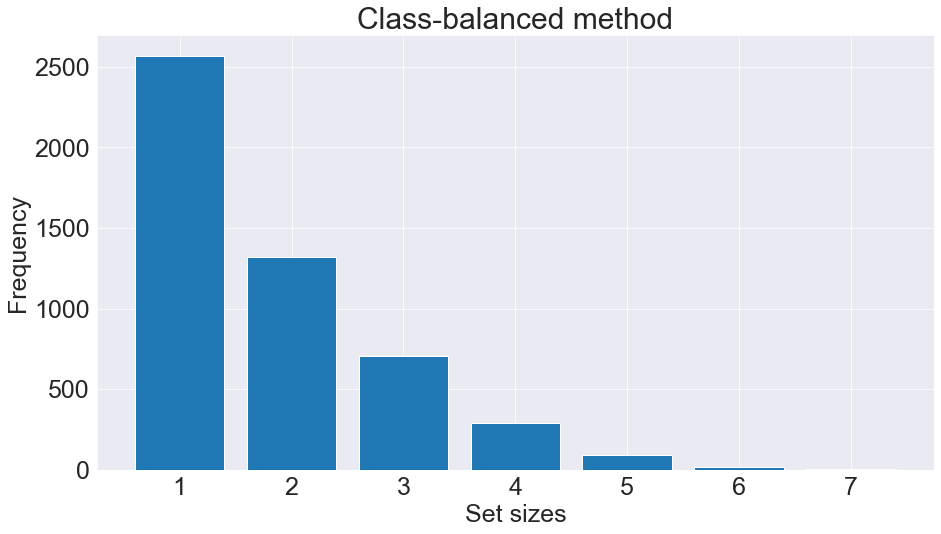

In [55]:
sets_dim=[len(set_conf) for set_conf in conf_sets]
plt.bar(dict(pd.Series(sets_dim).value_counts()).keys(),dict(pd.Series(sets_dim).value_counts()).values())
plt.xlabel('Set sizes')
plt.ylabel('Frequency')
plt.title('Class-balanced method')
plt.show()

Text(0, 0.5, 'Coverage')

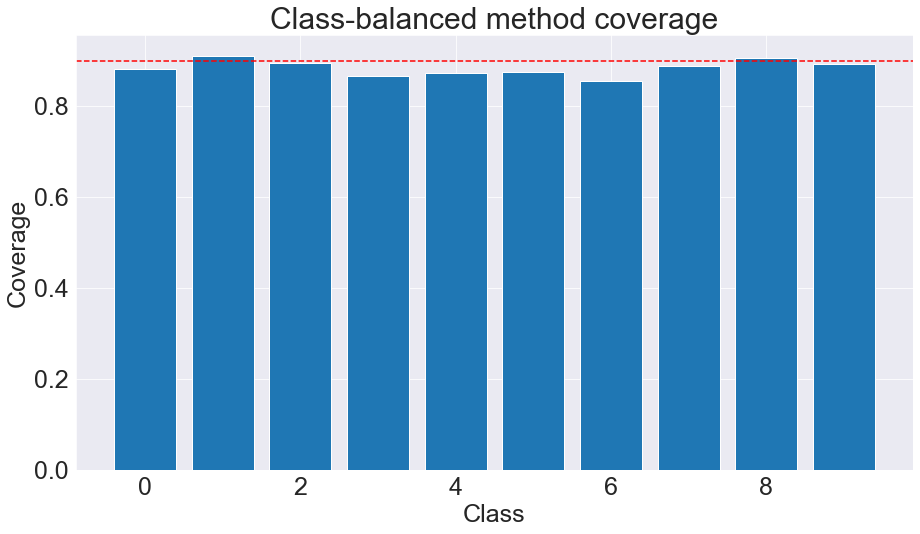

In [56]:
d1=np.zeros(10)
d2=np.zeros(10)

for i in range(len(conf_sets)):
    d2[y_val[i]]+=1
    
    if y_val[i] in conf_sets[i]:
        d1[y_val[i]]+=1




plt.bar([i for i in range(10)],d1/d2)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Class-balanced method coverage')
plt.xlabel('Class')
plt.ylabel('Coverage')